In [1]:
from PolyCAMB import *

Define the pivot LCDM cosmology as the Planck 2018 best fit.

In [2]:
ombh2 = 0.0224
omch2 = 0.120
ns = 0.965
tau = 0.054
ln10As = 3.043
As = np.exp(ln10As)*1e-10
H0 = 67.4

pivot_LCDM=np.array([ombh2, omch2, H0, ln10As, ns, tau])

# Set parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_for_lmax(2000, lens_potential_accuracy=0)

# Run the calculation
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
true_pivot_Dell_TT = powers['total'][:,0]

Generate an ensemble of cosmology around the pivot cosmology.

In [ ]:
N_params = len(pivot_LCDM)
N_samples = 1000  # Number of ensemble members to generate

# Generate perturbations (shape: (N_samples, N_params))
perturbations = np.random.normal(
    loc=0.0,  # Mean of perturbations
    scale=0.02 * pivot_LCDM,  # Std.dev = 10% of each parameter
    size=(N_samples, N_params)  # Desired output shape
)

perturbed_LCDM_params = pivot_LCDM + perturbations


# perturbed_LCDM_Dell = []
# for i in range(N_samples):
#     ombh2 = perturbed_LCDM_params[i, 0]
#     omch2 = perturbed_LCDM_params[i, 1]
#     H0 = perturbed_LCDM_params[i, 2]
#     ln10As = perturbed_LCDM_params[i, 3]
#     As = np.exp(ln10As)*1e-10
#     ns = perturbed_LCDM_params[i, 4]
#     tau = perturbed_LCDM_params[i, 5]

#     pars = camb.CAMBparams()
#     pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
#     pars.InitPower.set_params(As=As, ns=ns)
#     pars.set_for_lmax(2000, lens_potential_accuracy=0)
#     # Run the calculation
#     results = camb.get_results(pars)
#     powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
#     cls_TT = powers['total'][:,0]
#     perturbed_LCDM_Dell.append(cls_TT)

# perturbed_LCDM_Dell = np.array(perturbed_LCDM_Dell)

In [6]:
np.save('datasets/perturbed_LCDM_Dell.npy', perturbed_LCDM_Dell)

Generate (or load, if already generated) a set of CAMB power spectra.

In [ ]:
# X, Y, param_names, ells = generate_dataset(N=7, lmax=2000, ell_sampling=None, grid=True)

# # Save the parameter array
# np.save('datasets/camb_params_7.npy', X)

# # Save the output array
# np.save('datasets/camb_outputs_7.npy', Y)


In [4]:
X = np.load('datasets/camb_params_7.npy')
Y = np.load('datasets/camb_outputs_7.npy')

In [5]:
_, _, param_names, ells = generate_dataset(N=1, lmax=2000, ell_sampling=None, grid=False)

Running CAMB: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


## PolyCAMB_Dell (forward only)

In [7]:
from MomentEmu import *

In [8]:
PolyCAMB_Cl = PolyEmu(X, Y, RMSE_tol=0.001)

Generating forward emulator...
Forward emulator generated with degree 5, RMSE_val of 0.00022686296478799153.


In [9]:
pred_pivot_LCDM_Dell = PolyCAMB_Cl.forward_emulator(pivot_LCDM)
pred_perturbed_LCDM_Dell = PolyCAMB_Cl.forward_emulator(perturbed_LCDM_params)

## PolyCAMB_Peaks

In [11]:
training_peak_arr = peak_summary(Y, 5, tilt=True)

100%|██████████| 117649/117649 [00:02<00:00, 42741.73it/s]


In [12]:
test_peak_arr = peak_summary(perturbed_LCDM_Dell, 5, tilt=True)

100%|██████████| 1000/1000 [00:00<00:00, 40335.66it/s]


In [13]:
PolyCAMB_Peaks = PolyEmu(X, training_peak_arr, RMSE_tol=0.01,  backward=True, max_degree_backward=6)

Generating forward emulator...
Forward emulator generated with degree 2, RMSE_val of 0.00735070833098724.
Generating backward emulator...


In [14]:
Peaks_pred = PolyCAMB_Peaks.forward_emulator(perturbed_LCDM_params)

Params_inferred = PolyCAMB_Peaks.backward_emulator(test_peak_arr)

In [15]:
from visual import *


In [36]:
test_peak_arr.shape

(1000, 10)

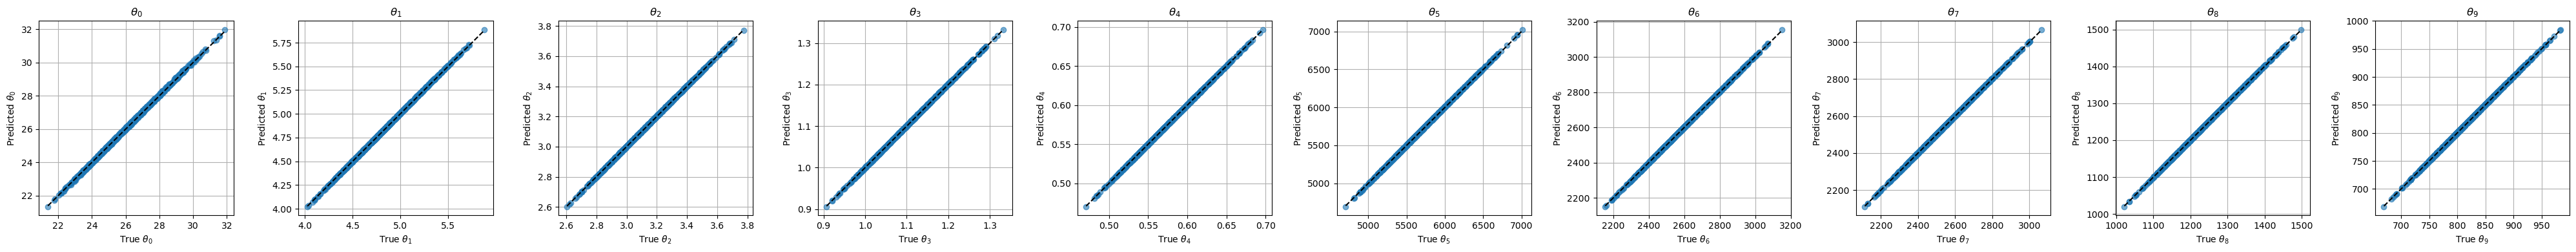

In [16]:
plot_predictions(test_peak_arr, Peaks_pred)

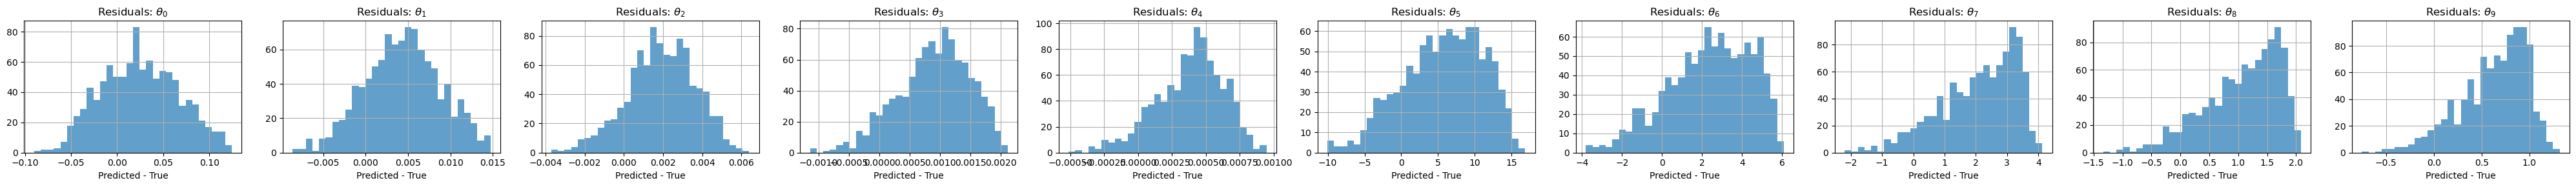

In [17]:
plot_residuals(test_peak_arr, Peaks_pred)

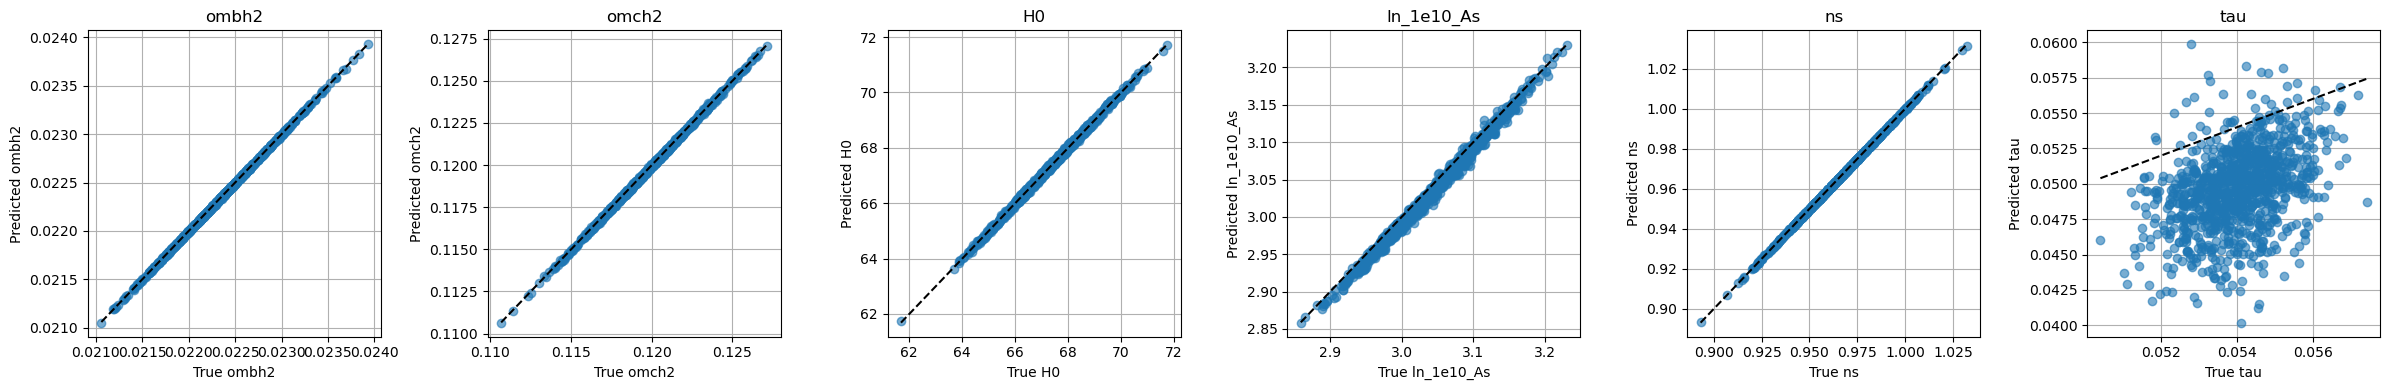

In [18]:
plot_predictions(perturbed_LCDM_params, Params_inferred, param_names=param_names)

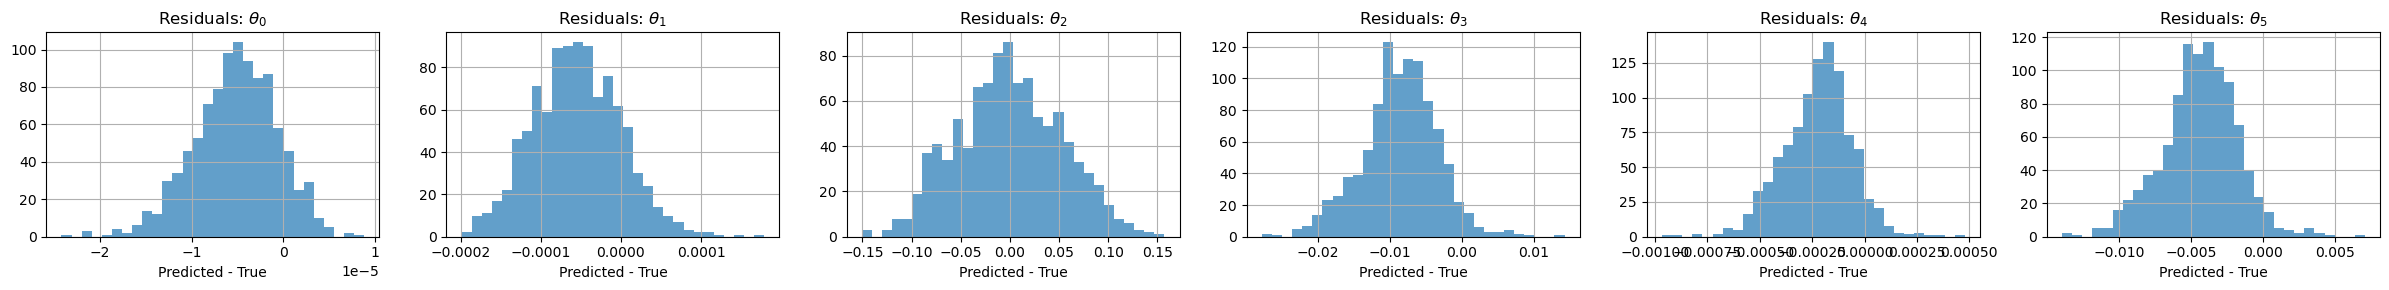

In [19]:
plot_residuals(perturbed_LCDM_params, Params_inferred)

In [ ]:
peak_pivot_LCDM = PolyCAMB_Peaks.forward_emulator(pivot_LCDM)
peak_pivot_ells, peak_pivot_Dell = peak_pos_hei(peak_pivot_LCDM)

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_51862/2403514088.py:44: SyntaxWarning: invalid escape sequence '\m'
  ax20.set_ylabel('Res. [$\mu K^2$]', fontsize=ftsize)
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_51862/2403514088.py:35: RuntimeWarning: invalid value encountered in divide
  ax10.plot(ells, (pred_pivot_LCDM_Dell[0] - true_pivot_Dell_TT) / true_pivot_Dell_TT * 100, color=color_ls[0])


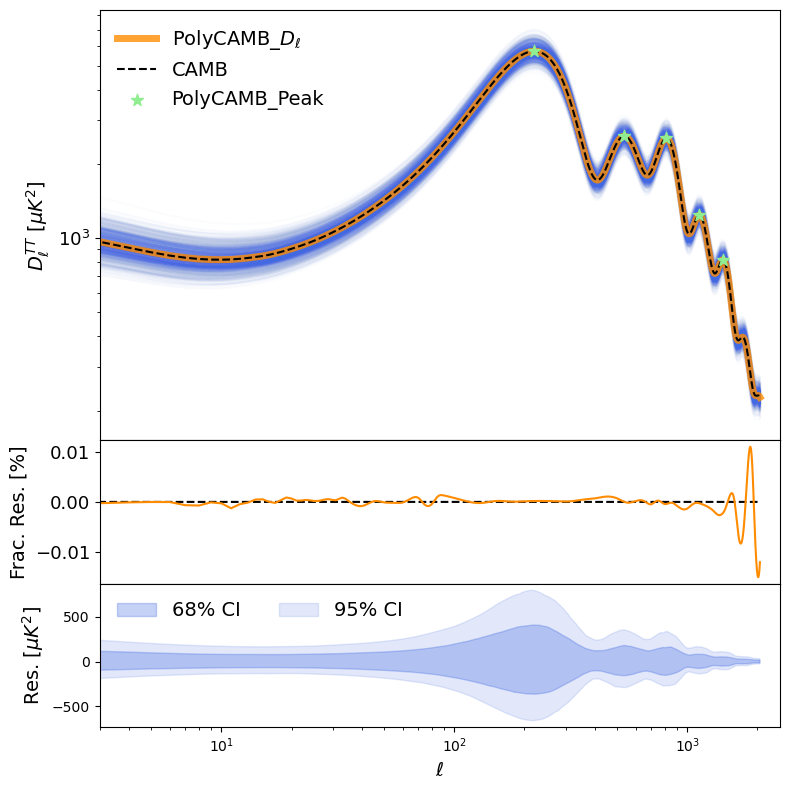

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

color_ls = ['DarkOrange', 'RoyalBlue', 'ForestGreen', 'Crimson', 'Purple', 'Gray']
ftsize = 14

residual_lower_1sigma = np.percentile(pred_perturbed_LCDM_Dell, 16, axis=0) - pred_pivot_LCDM_Dell[0]
residual_upper_1sigma = np.percentile(pred_perturbed_LCDM_Dell, 84, axis=0) - pred_pivot_LCDM_Dell[0]

residual_lower_2sigma = np.percentile(pred_perturbed_LCDM_Dell, 2.5, axis=0) - pred_pivot_LCDM_Dell[0]
residual_upper_2sigma = np.percentile(pred_perturbed_LCDM_Dell, 97.5, axis=0) - pred_pivot_LCDM_Dell[0]

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0.0)

ax00 = fig.add_subplot(gs[0])
for i in range(N_samples):
    ax00.plot(ells, pred_perturbed_LCDM_Dell[i], alpha=0.02,  color=color_ls[1])
ax00.plot(ells, pred_pivot_LCDM_Dell[0], alpha=0.8, lw=5, color=color_ls[0], label=r'PolyCAMB_$D_\ell$')
ax00.plot(ells, true_pivot_Dell_TT, linestyle='--', color='black', label=r'CAMB')
ax00.scatter(peak_pivot_ells, peak_pivot_Dell, color='lightgreen', label=r'PolyCAMB_Peak', marker='*', s=80,zorder=2)
ax00.set_xscale('log')
ax00.set_yscale('log')
#ax00.set_xlabel(r'$\ell$')
ax00.set_xlim(3, 2500)
# ax00.set_ylim(1,8000)
# D_ell is normalised C_ell
#plt.ylabel(r'$C_\ell\ell(\ell+1)/2\pi$')
ax00.set_ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]', fontsize=ftsize)
ax00.legend(loc='upper left', fontsize=ftsize, frameon=False)

ax10 = fig.add_subplot(gs[1], sharex=ax00)
ax10.plot(ells, 0 * ells, color='black', linestyle='--')
ax10.plot(ells, (pred_pivot_LCDM_Dell[0] - true_pivot_Dell_TT) / true_pivot_Dell_TT * 100, color=color_ls[0]) 
ax10.set_xlabel(r'$\ell$', fontsize=ftsize)
ax10.set_ylabel('Frac. Res. [%]', fontsize=ftsize)

ax20 = fig.add_subplot(gs[2], sharex=ax00)
ax20.fill_between(ells, residual_lower_1sigma, residual_upper_1sigma, color=color_ls[1], alpha=0.3, label='68% CI')
ax20.fill_between(ells, residual_lower_2sigma, residual_upper_2sigma, color=color_ls[1], alpha=0.15, label='95% CI')
ax20.legend(frameon=False, fontsize=ftsize, ncol=2)
ax20.set_xlabel(r'$\ell$', fontsize=ftsize)
ax20.set_ylabel('Res. [$\mu K^2$]', fontsize=ftsize)

# Set the fontsize for all tick labels and ticks
for ax in [ax00, ax10]:
    ax.tick_params(axis='both', which='major', labelsize=ftsize-1)
    ax.tick_params(axis='both', which='minor', labelsize=ftsize-1)
plt.tight_layout()
plt.savefig('figures/poly_camb.pdf', dpi=300)
plt.show()

In [24]:
import numpy as np

def l1_peak_location(ombh2, omch2, H0):
    """
    Approximate location of the first acoustic peak ℓ₁
    Based on simplified scaling relations.
    """
    ommh2 = ombh2 + omch2
    h = H0 / 100.0

    # Effective scaling based on Hu et al. / Dodelson
    ell1 = 300 * (H0 / 70.0)**0.5 * (ombh2)**(-0.1) * (omch2)**(-0.25)
    return ell1

def H1_peak_height(ombh2, omch2, As, tau):
    """
    Approximate height of the first peak H₁ in D_ell (up to a proportionality)
    """
    ommh2 = ombh2 + omch2

    baryon_ratio = ombh2 / omch2
    H1 = As * np.exp(-2 * tau) * (1 + baryon_ratio)**2.5 * (ommh2)**(-0.5)

    return H1


In [25]:
length = 100
ombh2_ls = np.linspace(ombh2*0.95, ombh2*1.05, length) 
omch2_ls = np.linspace(omch2*0.9, omch2*1.1, length)
H0_ls = np.linspace(H0*0.9, H0*1.1, length)
ln10As_ls = np.linspace(ln10As*0.95, ln10As*1.05, length)
As_ls = np.exp(ln10As_ls) * 1e-10
ns_ls = np.linspace(ns*0.95, ns*1.01, length)
tau_ls = np.linspace(tau*0.95, tau*1.05, length)

In [26]:
aux_params = np.ones((length,6))
aux_params *= pivot_LCDM[np.newaxis,:]

aux_params_ombh2 = aux_params.copy()
aux_params_ombh2[:,0] = ombh2_ls
aux_params_omch2 = aux_params.copy()
aux_params_omch2[:,1] = omch2_ls
aux_params_H0 = aux_params.copy()
aux_params_H0[:,2] = H0_ls
aux_params_As = aux_params.copy()
aux_params_As[:,3] = ln10As_ls
aux_params_tau = aux_params.copy()
aux_params_tau[:,5] = tau_ls

In [50]:
peak1_loc_theo_ombh2 = l1_peak_location(ombh2_ls, omch2, H0)
aux = PolyCAMB_Peaks.forward_emulator(aux_params_ombh2)
peak1_loc_pred_ombh2 = aux[:,5] / aux[:,0]  # Height / Tilt = Ell
norm_ombh2 = np.mean(peak1_loc_pred_ombh2/peak1_loc_theo_ombh2)
print(norm_ombh2)
peak1_loc_theo_ombh2 *= norm_ombh2

0.3073967455046087


In [51]:
peak1_height_theo_ombh2 = H1_peak_height(ombh2_ls, omch2, As, tau)
peak1_height_pred_ombh2 = PolyCAMB_Peaks.forward_emulator(aux_params_ombh2)[:,5]
norm_ombh2 = np.mean(peak1_height_pred_ombh2/peak1_height_theo_ombh2)
print(norm_ombh2)
peak1_height_theo_ombh2 *= norm_ombh2

724947364921.0568


In [52]:
peak1_loc_theo_omch2 = l1_peak_location(ombh2, omch2_ls, H0)
aux = PolyCAMB_Peaks.forward_emulator(aux_params_omch2)
peak1_loc_pred_omch2 = aux[:,5] / aux[:,0]
norm_omch2 = np.mean(peak1_loc_pred_omch2/peak1_loc_theo_omch2)
print(norm_omch2)
peak1_loc_theo_omch2 *= norm_omch2

0.30764672849214775


In [53]:
peak1_height_theo_omch2 = H1_peak_height(ombh2, omch2_ls, As, tau)
peak1_height_pred_omch2 = PolyCAMB_Peaks.forward_emulator(aux_params_omch2)[:,5]
norm_omch2 = np.mean(peak1_height_pred_omch2/peak1_height_theo_omch2)
print(norm_omch2)
peak1_height_theo_omch2 *= norm_omch2


727925483270.3843


In [54]:
peak1_loc_theo_As = l1_peak_location(ombh2, omch2, H0) * np.ones(length)
aux = PolyCAMB_Peaks.forward_emulator(aux_params_As)
peak1_loc_pred_As = aux[:,5] / aux[:,0]
norm_As = np.mean(peak1_loc_pred_As/peak1_loc_theo_As)
print(norm_As)
peak1_loc_theo_As *= norm_As

0.30724264313067795


In [55]:
peak1_height_theo_As = H1_peak_height(ombh2, omch2, As_ls, tau)
peak1_height_pred_As = PolyCAMB_Peaks.forward_emulator(aux_params_As)[:,5]
norm = np.mean(peak1_height_pred_As/peak1_height_theo_As)
print(norm)
peak1_height_theo_As *= norm



739802796321.6438


In [56]:
peak1_loc_theo_tau = l1_peak_location(ombh2, omch2, H0) * np.ones(length)
aux = PolyCAMB_Peaks.forward_emulator(aux_params_tau)
peak1_loc_pred_tau = aux[:,5] / aux[:,0]
norm_tau = np.mean(peak1_loc_pred_tau/peak1_loc_theo_tau)
print(norm_tau)
peak1_loc_theo_tau *= norm_tau

0.30724861793262515


In [57]:
peak1_height_theo_tau = H1_peak_height(ombh2, omch2, As, tau_ls)
peak1_height_pred_tau = PolyCAMB_Peaks.forward_emulator(aux_params_tau)[:,5]
norm_tau = np.mean(peak1_height_pred_tau/peak1_height_theo_tau)
print(norm_tau)
peak1_height_theo_tau *= norm_tau


720193660425.8207


In [58]:
peak1_loc_theo_H0 = l1_peak_location(ombh2, omch2, H0_ls) 
aux = PolyCAMB_Peaks.forward_emulator(aux_params_H0)
peak1_loc_pred_H0 = aux[:,5] / aux[:,0]
norm = np.mean(peak1_loc_pred_H0/peak1_loc_theo_H0)
print(norm)
peak1_loc_theo_H0 *= norm

0.3105946975025574


In [59]:
peak1_height_theo_H0 = H1_peak_height(ombh2, omch2, As, tau) * np.ones(length)
peak1_height_pred_H0 = PolyCAMB_Peaks.forward_emulator(aux_params_H0)[:,5]
norm = np.mean(peak1_height_pred_H0/peak1_height_theo_H0)
print(norm)
peak1_height_theo_H0 *= norm

722590028636.3239


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_51862/1403249325.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


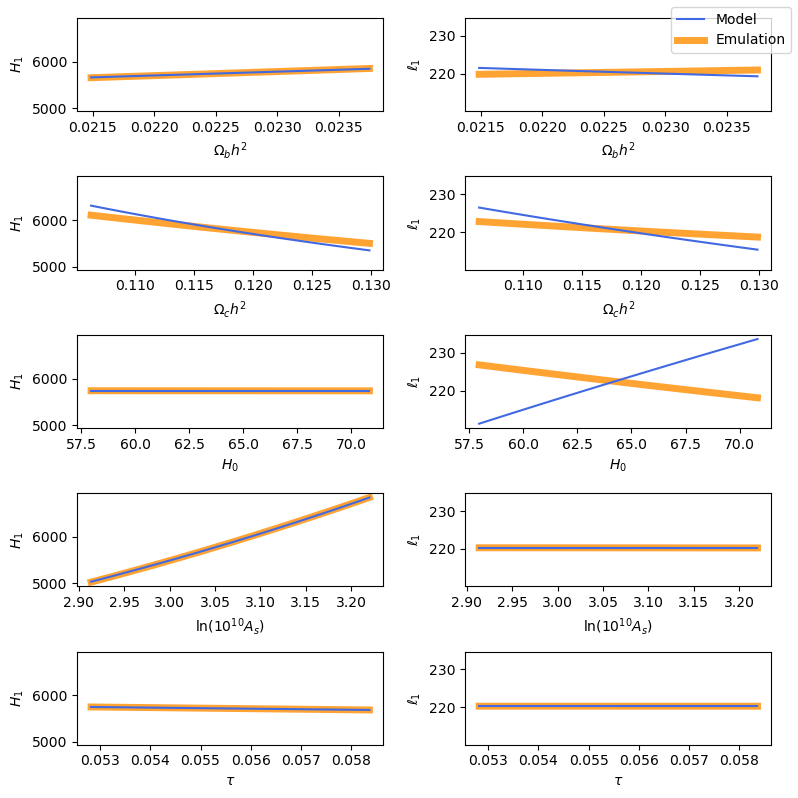

In [72]:

fig, ax = plt.subplots(nrows=5, ncols=2,  
                         figsize=(8, 8),
                         sharey='col',       # Share y-axis per column
                         constrained_layout=True)

xs_list = [ombh2_ls, omch2_ls, H0_ls, ln10As_ls, tau_ls ]
xs_labels = [r'$\Omega_b h^2$', r'$\Omega_c h^2$', r'$H_0$', r'$\ln(10^{10}A_s)$', r'$\tau$']

model_hei_ls = [peak1_height_theo_ombh2, peak1_height_theo_omch2, peak1_height_theo_H0, peak1_height_theo_As, peak1_height_theo_tau]
pred_hei_ls = [peak1_height_pred_ombh2, peak1_height_pred_omch2, peak1_height_pred_H0, peak1_height_pred_As, peak1_height_pred_tau]

model_loc_ls = [peak1_loc_theo_ombh2, peak1_loc_theo_omch2, peak1_loc_theo_H0, peak1_loc_theo_As, peak1_loc_theo_tau]
pred_loc_ls = [peak1_loc_pred_ombh2, peak1_loc_pred_omch2, peak1_loc_pred_H0, peak1_loc_pred_As, peak1_loc_pred_tau]


for i in range(5):
    xs = xs_list[i]
    xs_label = xs_labels[i]
    model_hei = model_hei_ls[i]
    pred_hei = pred_hei_ls[i]
    model_loc = model_loc_ls[i]
    pred_loc = pred_loc_ls[i]

    Emu_line, = ax[i, 0].plot(xs, pred_hei, color=color_ls[0], lw=5, alpha=0.8)
    model_line, = ax[i, 0].plot(xs, model_hei, color=color_ls[1])
    ax[i, 0].set_xlabel(xs_label)
    ax[i, 0].set_ylabel(r'$H_1$')
    #ax[i, 0].set_ylim(5200, 7000)
    ax[i, 1].plot(xs, pred_loc, color=color_ls[0], lw=5, alpha=0.8)
    ax[i, 1].plot(xs, model_loc, color=color_ls[1])
    ax[i, 1].set_xlabel(xs_label)
    ax[i, 1].set_ylabel(r'$\ell_1$')

# Create figure-level legend
fig.legend(
    [model_line, Emu_line],  # Handles from your plots
    ['Model', 'Emulation'],  # Labels
    loc='upper right',        # Anchor point position
    #bbox_to_anchor=(0.21, 0.05),  # Position in figure coordinates
    bbox_transform=fig.transFigure  # Use figure coordinate system
)
plt.tight_layout()
plt.show()


    